In [70]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({ 'axes.spines.left': False, 'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': False })

%matplotlib inline

# Adjusting for population

## The "Texas/California Problem"

> "When you have states with big populations or places with a large population of one specific type, **your data may simply be representing population and nothing else.** So normalizing for population or understanding your data, to begin with, are both important steps. It's not enough to scrape it and chart it, you need to step back and understand what you are looking at. Just watch out for big populations."

Let's say we're graphing how many **central libraries** are in each state. We pull in the data, it has the state and the number of libraries, and we graph it.

## Adjusting for population with long (normal) data

In [72]:
df = pd.read_csv("libraries.csv")
df.head()

state  libraries
0     Alabama        284
1      Alaska        102
2     Arizona        185
3    Arkansas        210
4  California       1084

Text(0,1,'Libraries per state')

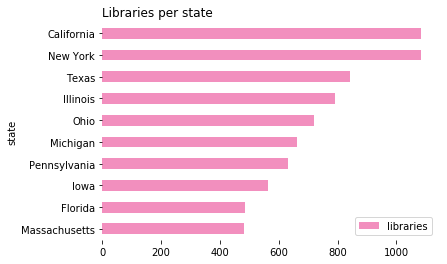

In [97]:
ax = df.sort_values(by='libraries').tail(10).plot(x='state', y='libraries', kind='barh', color='#F28FBE')
ax.set_title('Libraries per state', loc='left')

According to this map, **California, New York, and Texas all have the most libraries.** There's something we're forgetting, though, and it's that **CA, NY and TX *also* all have the most people.**

More people = more libraries. We're basically making a graph of libraries that's a proxy for population!

To fix this, we need to **adjust for population**, and make it a per-capita (per person) graph.

### Step 1: Read in your population data

Make sure it has a **matching column to your original data,** whether it's state name, country name, borough name, census code, etc.

In [98]:
pop = pd.read_csv("population.csv")
pop.head()

State or territory  Population
0         California    39250017
1              Texas    27862596
2            Florida    20612439
3           New York    19745289
4           Illinois    12801539

### Step 2: Join the population data to your original data

Using `.merge` and `left_on` + `right_on` (the column names they have in common) you can easily join your population data to your original data.

In [99]:
merged = df.merge(pop, left_on='state', right_on='State or territory')
merged.head()

state  libraries State or territory  Population
0     Alabama        284            Alabama     4863300
1      Alaska        102             Alaska      741894
2     Arizona        185            Arizona     6931071
3    Arkansas        210           Arkansas     2988248
4  California       1084         California    39250017

### Step 3: Do the math

In [100]:
merged['libraries_per_capita'] = merged['libraries'] / merged['Population']
merged.head()

state  libraries State or territory  Population  libraries_per_capita
0     Alabama        284            Alabama     4863300              0.000058
1      Alaska        102             Alaska      741894              0.000137
2     Arizona        185            Arizona     6931071              0.000027
3    Arkansas        210           Arkansas     2988248              0.000070
4  California       1084         California    39250017              0.000028

### Step 4: Adjust the math

`0.000058` libraries per person" just doesn't sound interesting! For smaller numbers, you'll want to make it "per 100 people," per 10,000 people," or even per *million people*.

In [101]:
merged['libraries_per_100k_people'] = merged['libraries'] / merged['Population'] * 100000
merged.head()

state  libraries State or territory  Population  libraries_per_capita  \
0     Alabama        284            Alabama     4863300              0.000058   
1      Alaska        102             Alaska      741894              0.000137   
2     Arizona        185            Arizona     6931071              0.000027   
3    Arkansas        210           Arkansas     2988248              0.000070   
4  California       1084         California    39250017              0.000028   

   libraries_per_100k_people  
0                   5.839656  
1                  13.748595  
2                   2.669140  
3                   7.027529  
4                   2.761782

Text(0,1,'Libraries per 100,000 residents')

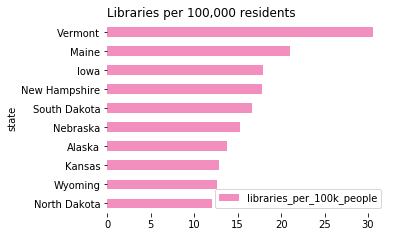

In [104]:
ax = merged.sort_values(by='libraries_per_100k_people').tail(10).plot(x='state', y='libraries_per_100k_people', kind='barh', color='#F28FBE', figsize=(5,3.5))
ax.set_title("Libraries per 100,000 residents", loc='left')

### Step 5: Celebrate

Look at that, we've actually got a somewhat-interesting story! Instead of New York, California and Texas having the most, it looks like Vermont is *way ahead of everyone else.* Something to investigate, perhaps?

# Adjusting for population with wide data (or adjusting for multiple places over multiple years)

Adjusting for population with *wide data* is a little bit different. Not just because you'll need to adjust for multiple places over multiple years, but because you need to do it across *multiple columns*.

If you had long data you could just join on multiple columns and do simple math, but with wide data you gotta get a little fancy.

### Step 1: Read in your data

This is how many ice cream shops were in Staten Island, Manhattan, and Brooklyn in 1850, 1900, 1950 and 2000 (not real data, sadly).

In [168]:
df = pd.read_csv("borough-ice-cream.csv")
df.head()

year  Staten Island  Brooklyn  Manhattan
0  1850              2         8         10
1  1900              4        44         34
2  1950             10        34         44
3  2000             50       250        100

Text(0,1,'Number of ice cream shops')

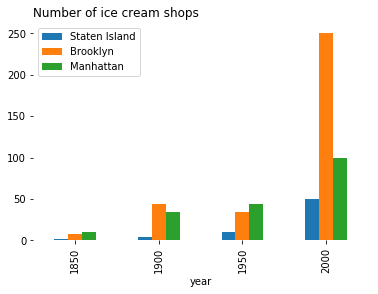

In [169]:
ax = df.plot(x='year', kind='bar')
ax.set_title("Number of ice cream shops", loc='left')

But of course, **if there are more people there should be more ice cream shops,** so we should adjust for population. It's kind of weird since we have wide data, but we can do it!

### Step 2: Prepare your population data

Because we have multiple areas over multiple years, we can't just say "I want the population of Staten Island in 1850, 1900, 1950 and 2000" - we need the populations of *every borough* in *each year*. Our data will look like this:

In [170]:
pop = pd.read_csv("borough-population.csv")
pop.head()

year  Staten Island  Brooklyn  Manhattan
0  1850          15061    138822     515547
1  1900          67021   1166582    1850093
2  1950         191555   2738175    1960101
3  2000         443728   2465326    1537195

I actually had to make this data by hand! You probably will, too. **Make the rows and columns match up with your dataframe.** Notice how I have the same years and the same column headers.

### Step 3: Divide your data.

Just like we did before, we divide. But this time we need to divide each cell by the same cell in the other dataframe!

To make this work best, we're going to **change the index of the dataframes**. When we do our math, it's going to do it to **every single cell**, and we don't want to divide the years, so we keep them safe in the index.

In [171]:
# Ice cream shops
df.set_index('year', inplace=True)
df.head()

Staten Island  Brooklyn  Manhattan
year                                    
1850              2         8         10
1900              4        44         34
1950             10        34         44
2000             50       250        100

In [172]:
# Population
pop.set_index('year', inplace=True)
pop.head()

Staten Island  Brooklyn  Manhattan
year                                    
1850          15061    138822     515547
1900          67021   1166582    1850093
1950         191555   2738175    1960101
2000         443728   2465326    1537195

Once we've made sure they match, we'll do `df.div` to divide a dataframe by another dataframe. This divides **each cell by the matching cell in the other dataframe**.

In [173]:
per_capita = df.div(pop)
per_capita

Staten Island  Brooklyn  Manhattan
year                                    
1850       0.000133  0.000058   0.000019
1900       0.000060  0.000038   0.000018
1950       0.000052  0.000012   0.000022
2000       0.000113  0.000101   0.000065

Looking pretty good! Let's multiply by 100000 to make it per 100000 people.

In [174]:
per_capita = df.div(pop) * 100000
per_capita

Staten Island   Brooklyn  Manhattan
year                                     
1850      13.279331   5.762775   1.939687
1900       5.968279   3.771702   1.837745
1950       5.220433   1.241703   2.244782
2000      11.268164  10.140647   6.505356

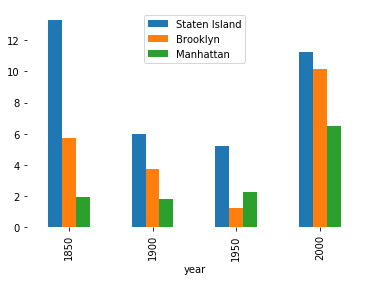

In [175]:
per_capita.plot(kind='bar')

While our original chart had Brooklyn as loving ice cream the most, it looks like Staten Island wins if we look at things per-capita!

### Step 4: Getting our old data back

Remember how we set the index to be the year?

In [151]:
df

Staten Island  Brooklyn  Manhattan
year                                    
1850              5         8         10
1900              4        44         34
1950             10        34         44
2000             15       250        100

If we want the year back as a normal column, we just do a `.reset_index(inplace=True)`

In [153]:
df.reset_index(inplace=True)
df.head()

year  Staten Island  Brooklyn  Manhattan
0  1850              5         8         10
1  1900              4        44         34
2  1950             10        34         44
3  2000             15       250        100